In [5]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# We will build just a simple conv-dense model
from keras import Sequential
from keras.layers import Conv2D, Flatten, Dense

# One-hot-encode categoricals
from keras.utils import to_categorical


# Visualize the network
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot


train = pd.read_csv("../data/base/train.csv")
y_train = to_categorical(train.iloc[:, 0]) 
train = train.iloc[:, 1:]

test = pd.read_csv("../data/base/test.csv")

X_train = train.values.reshape((train.shape[0], 28, 28, 1))
X_test = test.values.reshape((test.shape[0], 28, 28, 1))

X_train.shape, y_train.shape, X_test.shape

((42000, 28, 28, 1), (42000, 10), (28000, 28, 28, 1))

# Simple Keras model

In [4]:
def model1():
    m = Sequential()
    m.add(Conv2D(10, (4,4), input_shape=(28,28,1,)))
    m.add(Flatten())
    m.add(Dense(10, activation='softmax'))
    m.compile(loss='categorical_crossentropy', optimizer='adam')
    return m

In [6]:
m = model1()

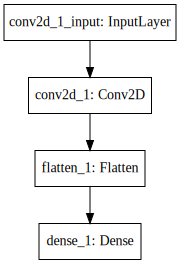

In [23]:
def plot(model, show_shapes=False):
    display(SVG(model_to_dot(model, show_shapes=show_shapes).create(prog='dot', format='svg')))
    plt.show()
    
plot(m)

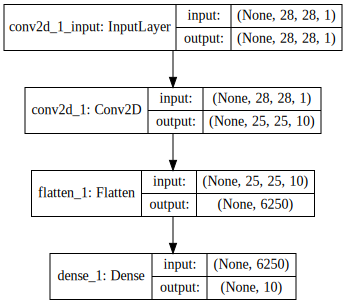

In [24]:
plot(m, show_shapes=True)

In [25]:
m.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 25, 25, 10)        170       
_________________________________________________________________
flatten_1 (Flatten)          (None, 6250)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                62510     
Total params: 62,680
Trainable params: 62,680
Non-trainable params: 0
_________________________________________________________________


In [26]:
# Two lines is the minimum code I could get preserving readability
# compile() doesn't return self
m2 = Sequential(layers=[Conv2D(10, (4,4), input_shape=(28,28,1,)), Flatten(), Dense(10, activation='softmax')])
m2.compile(loss='categorical_crossentropy', optimizer='adam')
m2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 25, 25, 10)        170       
_________________________________________________________________
flatten_6 (Flatten)          (None, 6250)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)                62510     
Total params: 62,680
Trainable params: 62,680
Non-trainable params: 0
_________________________________________________________________


In [27]:
m.fit(X_train, y_train, epochs=1)

Epoch 1/1
42000/42000 [==============================] - 14s 335us/step - loss: 8.1919


In [42]:

y_pred = m.predict(X_test)

# The prediction comes as a one-hot-encoding of the class
print(y_pred.shape)
y_pred[:3,0:10]

(28000, 10)


array([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]], dtype=float32)

In [44]:
# np.argmax(..., axis=-1) is the inverse of to_categorical()
np.argmax(y_pred[:3,0:10], axis=-1)

array([2, 7, 8])

In [157]:

SUBMISSION_PATH="../data/submissions/"

def submit(model, X_test, submission_name):
    
    pd.DataFrame({
                    'ImageId': range(1, 28001), 
                    'Label': np.argmax(model.predict(X_test), axis=-1)}
                ).to_csv(f"{SUBMISSION_PATH}{submission_name}.csv", index=False)
    
submit(m, X_test, submission_name)

# Some utility functions

In [64]:
import subprocess

def run(command, print_output=True):
    out = subprocess.check_output(command, shell=True).decode('utf-8')
    if print_output:
        print(out)
    return out

In [67]:
out = run("ls -l")

total 180
-rw-rw-r-- 1 plotinus plotinus 82395 nov 12 20:36 1-first-contact.ipynb
-rw-rw-r-- 1 plotinus plotinus 69846 nov  8 22:57 2-answer-stackoverflow-question.ipynb
-rw-rw-r-- 1 plotinus plotinus 19931 nov 12 21:34 2-keras-basic.ipynb
drwxrwxr-x 2 plotinus plotinus  4096 nov  8 22:20 kaggle



In [85]:
submissions = run("/home/plotinus/anaconda3/bin/kaggle competitions submissions digit-recognizer")

fileName                         date                 description                                                                                status    publicScore  privateScore  
-------------------------------  -------------------  -----------------------------------------------------------------------------------------  --------  -----------  ------------  
dummy_cuadrant_resolution_4.csv  2018-11-09 04:11:23                                                                                             complete  0.88485      None          
dummy_2_features_log_reg.csv     2018-11-09 03:37:48  Dummy: logistic regression with sum of brighness and count of non zero pixels as features  complete  0.12842      None          
dummy_all_ones.csv               2018-11-09 02:43:28  Dummy all ones                                                                             complete  0.11614      None          
sample_submission.csv            2018-11-09 02:22:35  This is the sample submission  

In [131]:
lines = [line.split() for line in submissions.split("\n")[2:-1]]
lines[0]

['dummy_cuadrant_resolution_4.csv',
 '2018-11-09',
 '04:11:23',
 'complete',
 '0.88485',
 'None']

In [130]:
df = pd.DataFrame([(e[0], f"{e[1]} {e[2]}", float(e[-2])) for e in lines], 
                   columns=['submission', 'date', 'accuracy']).set_index('submission')
df

,date,accuracy
submission,,
dummy_cuadrant_resolution_4.csv,2018-11-09 04:11:23,0.88485
dummy_2_features_log_reg.csv,2018-11-09 03:37:48,0.12842
dummy_all_ones.csv,2018-11-09 02:43:28,0.11614
sample_submission.csv,2018-11-09 02:22:35,0.10014
sample_submission.csv,2018-11-09 02:21:10,0.10014


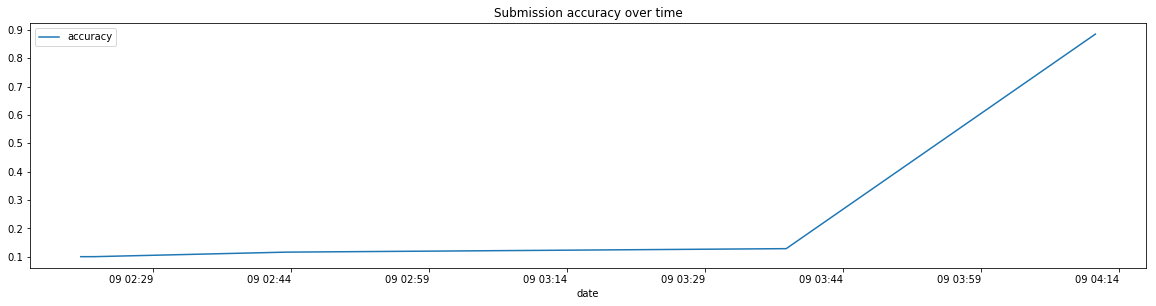

In [134]:
df['date'] = pd.to_datetime(df['date'])
df[['date', 'accuracy']].set_index('date').plot(figsize=(20, 5), rot=0, title="Submission accuracy over time")

In [140]:

KAGGLE_CMD="/home/plotinus/anaconda3/bin/kaggle"

def check_submissions(show=False):
    submissions = run(f"{KAGGLE_CMD} competitions submissions digit-recognizer", print_output=False)
    lines = [line.split() for line in submissions.split("\n")[2:-1]]
    df = pd.DataFrame([(e[0], f"{e[1]} {e[2]}", float(e[-2])) for e in lines], 
                   columns=['submission', 'date', 'accuracy']).set_index('submission')
    
    df['date'] = pd.to_datetime(df['date'])
    
    if show:
        df[['date', 'accuracy']].set_index('date').plot(figsize=(20, 5), rot=0, 
                                                        title="Submission accuracy over time")
        plt.show()
        display(df)
    
    return df

check_submissions()

,date,accuracy
submission,,
dummy_cuadrant_resolution_4.csv,2018-11-09 04:11:23,0.88485
dummy_2_features_log_reg.csv,2018-11-09 03:37:48,0.12842
dummy_all_ones.csv,2018-11-09 02:43:28,0.11614
sample_submission.csv,2018-11-09 02:22:35,0.10014
sample_submission.csv,2018-11-09 02:21:10,0.10014


In [143]:
run(f"ls -l {SUBMISSION_PATH}");

total 1276
-rw-rw-r-- 1 plotinus plotinus 212908 nov  9 00:36 dummy_2_features_log_reg.csv
-rw-rw-r-- 1 plotinus plotinus 212908 nov  8 23:42 dummy_all_ones.csv
-rw-rw-r-- 1 plotinus plotinus 212908 nov  9 01:34 dummy_cuadrant_resolution_3.csv
-rw-rw-r-- 1 plotinus plotinus 212908 nov  9 01:11 dummy_cuadrant_resolution_4.csv
-rw-rw-r-- 1 plotinus plotinus 212908 nov 12 22:07 keras_model_1.csv
-rw-rw-r-- 1 plotinus plotinus 240909 nov  8 23:19 sample_submission.csv



In [144]:
submission = "keras_model_1"
run(f"{KAGGLE_CMD} competitions submit -f {SUBMISSION_PATH}/{submission}.csv -m '{submission}.csv' digit-recognizer");

Successfully submitted to Digit Recognizer


In [150]:
# The plot is ugly, because of the time difference among submissions so I just show the table
submissions = check_submissions()
submissions

,date,accuracy
submission,,
keras_model_1.csv,2018-11-13 01:09:58,0.52800
dummy_cuadrant_resolution_4.csv,2018-11-09 04:11:23,0.88485
dummy_2_features_log_reg.csv,2018-11-09 03:37:48,0.12842
dummy_all_ones.csv,2018-11-09 02:43:28,0.11614
sample_submission.csv,2018-11-09 02:22:35,0.10014
sample_submission.csv,2018-11-09 02:21:10,0.10014


In [156]:
submissions.loc[f"{submission}.csv", "accuracy"]

0.528

OK, let's put all this together in a simple function

In [165]:
import time

TEST = "../data/base/test.csv"

def submit_to_server(submission, check=True):
    
    run(f"{KAGGLE_CMD} competitions submit -f {SUBMISSION_PATH}/{submission}.csv -m '{submission}.csv' digit-recognizer", 
            print_output=True)
    
    if check:
        print("Sleeping 30 secs before checking for score...")
        time.sleep(30)
        submissions = check_submissions()
        acc = submissions.loc[f"{submission}.csv", "accuracy"]
        print(f"Model accuracy is {acc}")
        return acc
    

def submit(model, submission_name, submit_to_kaggle=False):
    
    test = pd.read_csv(TEST)
    X_test = test.values.reshape((test.shape[0], 28, 28, 1))
    pd.DataFrame({
                    'ImageId': range(1, 28001), 
                    'Label': np.argmax(model.predict(X_test), axis=-1)}
                ).to_csv(f"{SUBMISSION_PATH}{submission_name}.csv", index=False)

    if submit_to_kaggle:
        acc = submit_to_server(submission_name)
        return acc


# Let's fit this model for some epochs more

In [148]:
h = m.fit(X_train, y_train, epochs=10)

Epoch 1/10
42000/42000 [==============================] - 13s 306us/step - loss: 7.4131
Epoch 2/10
42000/42000 [==============================] - 13s 299us/step - loss: 7.2698
Epoch 3/10
42000/42000 [==============================] - 13s 302us/step - loss: 7.4104
Epoch 4/10
42000/42000 [==============================] - 13s 303us/step - loss: 7.3597
Epoch 5/10
42000/42000 [==============================] - 13s 303us/step - loss: 7.2929
Epoch 6/10
42000/42000 [==============================] - 13s 301us/step - loss: 7.3267
Epoch 7/10
42000/42000 [==============================] - 14s 326us/step - loss: 6.4603
Epoch 8/10
42000/42000 [==============================] - 13s 313us/step - loss: 6.2564
Epoch 9/10
42000/42000 [==============================] - 13s 307us/step - loss: 6.0608
Epoch 10/10
42000/42000 [==============================] - 13s 315us/step - loss: 6.0173


It seems that it started to improve after a while!

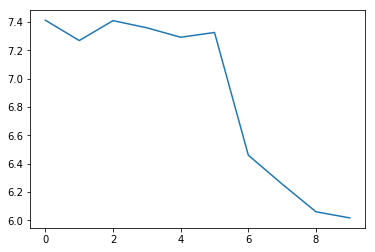

In [164]:
plt.plot(h.history['loss'])

In [166]:
submit(m, "keras_model_1_11_epochs", submit_to_kaggle=True)

Successfully submitted to Digit Recognizer
Sleeping 30 secs before checking for score...
Model accuracy is 0.62214


0.62214

### 9 extra epoch eventually found a jump in accuracy which lead to a %10 improvement

# Let's complete 100 epochs

In [167]:
%%time
h = m.fit(X_train, y_train, epochs=89)

Epoch 1/89
42000/42000 [==============================] - 13s 304us/step - loss: 5.9164
Epoch 2/89
42000/42000 [==============================] - 14s 323us/step - loss: 5.9822
Epoch 3/89
42000/42000 [==============================] - 13s 300us/step - loss: 6.0588
Epoch 4/89
42000/42000 [==============================] - 13s 299us/step - loss: 6.1395
Epoch 5/89
42000/42000 [==============================] - 13s 305us/step - loss: 5.8615
Epoch 6/89
42000/42000 [==============================] - 13s 304us/step - loss: 5.7947
Epoch 7/89
42000/42000 [==============================] - 13s 305us/step - loss: 6.0872
Epoch 8/89
42000/42000 [==============================] - 13s 320us/step - loss: 5.7472
Epoch 9/89
42000/42000 [==============================] - 13s 309us/step - loss: 5.7314
Epoch 10/89
42000/42000 [==============================] - 13s 312us/step - loss: 5.7638
Epoch 11/89
42000/42000 [==============================] - 13s 312us/step - loss: 5.7201
Epoch 12/89
42000/42000 [=====

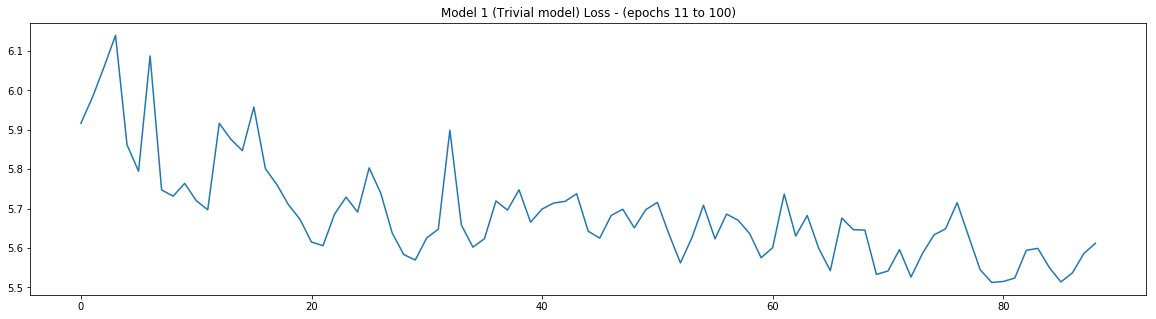

In [174]:
pd.Series(h.history['loss']).plot(figsize=(20, 5), title="Model 1 (Trivial model) Loss - (epochs 11 to 100)");

In [175]:
submit(m, "keras_model_1_100_epochs", submit_to_kaggle=True)

Successfully submitted to Digit Recognizer
Sleeping 30 secs before checking for score...
Model accuracy is 0.64814


0.64814

It reported a 2.6% improvement in accuracy

In [176]:
check_submissions()

,date,accuracy
submission,,
keras_model_1_100_epochs.csv,2018-11-13 01:52:07,0.64814
keras_model_1_11_epochs.csv,2018-11-13 01:29:00,0.62214
keras_model_1.csv,2018-11-13 01:09:58,0.52800
dummy_cuadrant_resolution_4.csv,2018-11-09 04:11:23,0.88485
dummy_2_features_log_reg.csv,2018-11-09 03:37:48,0.12842
dummy_all_ones.csv,2018-11-09 02:43:28,0.11614
sample_submission.csv,2018-11-09 02:22:35,0.10014
sample_submission.csv,2018-11-09 02:21:10,0.10014
